<a href="https://colab.research.google.com/github/yda-cyber/Hallucinator/blob/main/Hallucinator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Install Dependencies
# @markdown Install ESMFold, OpenFold and Hallucinator
# @markdown - This will approximately use 5.5 minutes
# @markdown - ESMFold can be used from ESMFold API (online, without GPU). Typically Faster for small proteins.

useESMFold = "online" # @param ["local", "online"]

import os
import time

os.system("pip install pyKVFinder==0.6.0")
os.system("pip install numpy==1.23.5")
os.system("git clone https://github.com/yda-cyber/Hallucinator.git")

# Install ADFR
if not os.path.isfile('install-ADFR'):
  print("[PREPR]: Installing ADFR.")
  os.system("wget -O install-ADFR https://ccsb.scripps.edu/adfr/download/1028/")
  os.system("chmod a+x install-ADFR")
  !echo -e "Y\n ADFR" | ./install-ADFR >/dev/null 2>&1
  os.chdir('ADFR/')
  os.system('tar -zxvf ADFRsuite_x86_64Linux_1.0.tar.gz')
  os.chdir('ADFRsuite_x86_64Linux_1.0/')
  os.system('echo -e "Y" | ./install.sh >/dev/null 2>&1')
  os.system('cp bin/prepare_receptor ../../.')
  os.chdir('../..')

if not os.path.isfile('qvina-w'):
  print("[PREPR]: Installing Qvina-W.")
  os.system("git clone https://github.com/QVina/qvina.git")
  os.system("chmod +x qvina/bin/qvina-w")
  os.system("cp qvina/bin/qvina-w .")

os.makedirs("results", exist_ok=True)
os.makedirs("molecules", exist_ok=True)

if useESMFold == 'local':
  if not os.path.isfile("esmfold.model"):

    os.system("apt-get install aria2 -qq")
    print("[PREPR]: Downloading ESMFold from ColabFold.")
    os.system(f"aria2c -q -x 16 https://colabfold.steineggerlab.workers.dev/esm/esmfold.model &")

    # wait for Params to finish downloading...
    if os.path.isfile(f"esmfold.model.aria2"):
      print("[PREPR]: Downloading in progress.")
    while os.path.isfile(f"esmfold.model.aria2"):
      time.sleep(5)

    if not os.path.isfile("FoldInstalled.state"):
      commit_id = "6908936b68ae89f67755240e2f588c09ec31d4c8"
      print("[PREPR]: Installing ESMfold Dependencies.")
      os.system("pip install -q omegaconf \"pytorch_lightning<2\" \"torch<2\" biopython ml_collections einops py3Dmol")
      os.system("pip install -q git+https://github.com/NVIDIA/dllogger.git")
      os.system(f"pip install -q git+https://github.com/aqlaboratory/openfold.git@{commit_id}")
      print("[PREPR]: Installing ESMfold")
      os.system("pip install -q git+https://github.com/sokrypton/esm.git")
      os.system("touch FoldInstalled.state")

In [ ]:
#@title Import Losses and Modules

from Hallucinator.ProteinHallucination import Protein_History_MCMC_Logger

from Hallucinator.modules.Predict_ESM import predict_esm
from Hallucinator.modules.Compute_RMSD import compute_rmsd
from Hallucinator.modules.Init_Sequence import init_sequence
from Hallucinator.modules.Select_Mutation import select_mutation
from Hallucinator.modules.Mutations_BLOSUM62 import mutation_blosum62

from Hallucinator.loss.Loss_Function import LossFunction

from Hallucinator.loss.Compute_Cavity_Volume_Loss import CavityVolumeLoss
from Hallucinator.loss.Compute_Local_Distance_Loss import LocalDistanceLoss
from Hallucinator.loss.Compute_Secondary_Ratio_Loss import SecondaryRatioLoss
from Hallucinator.loss.Compute_Contact_Density_Loss import ContactDensityLoss
from Hallucinator.loss.Compute_Cavity_Similarity_Loss import CavitySimilarityLoss
from Hallucinator.loss.Compute_Cavity_Containing_Loss import CavityContainingLoss
from Hallucinator.loss.Compute_Protein_Containing_Loss import ProteinContainingLoss
from Hallucinator.loss.Compute_Preserve_Structure_Loss import PreserveStructureLoss
from Hallucinator.loss.Compute_Truncated_Average_PLDDT_Loss import TruncatedAveragePLDDTLoss
from Hallucinator.loss.Compute_Molecule_Binding_Affinity_Loss import MoleculeBindingAffinityLoss
from Hallucinator.loss.Compute_Cavity_Containing_Flexible_Loss import CavityContainingFlexibleLoss

In [ ]:
#@title Basic Settings
Jobname = 'FixSequenceTest2' #@param {type:"string"}
Length = 80 #@param {type: "number"}
Steps = 10000 #@param {type: "number"}
Output_Render_Frequency = 100 #@param {type: 'number'}
Start_From_Known_Sequence = False #@param {type:"boolean"}
#@markdown - Only when you select to start from known sequence, the Intial Sequence and Preservation will be used
Initial_Sequence = 'PIAQIHILEGRSDEQKETLIREVSEAISRSLDAPLTSVRVIITEMAKGHFGIGGELASK' #@param {type:"string"}
Initial_Mutation_Rate = 30 #@param {type:"number"}
Preserved_Residues = "1; 10; 11" #@param {type:"string"}
#@markdown - Use ; to seperate unwanted amino acids
Exclude_Amino_Acid = "C;H" #@param {type:"string"}
#@markdown - Number of guesses before starting hallucination
N_Free_Guess = 0 #@param [0, 5, 10]
#@markdown - Rules for mixing multiple losses
Loss_Rule = 'Sum' #@param ['Sum', 'Max']


[MBLRF]: Computing Average Binding Affinity for 50 Reference PDBs
[MBLRF]: This will take several minutes.
Hallucinator/molecules/Example.pdb
[CSLOG]: Targeted volume is 177.98


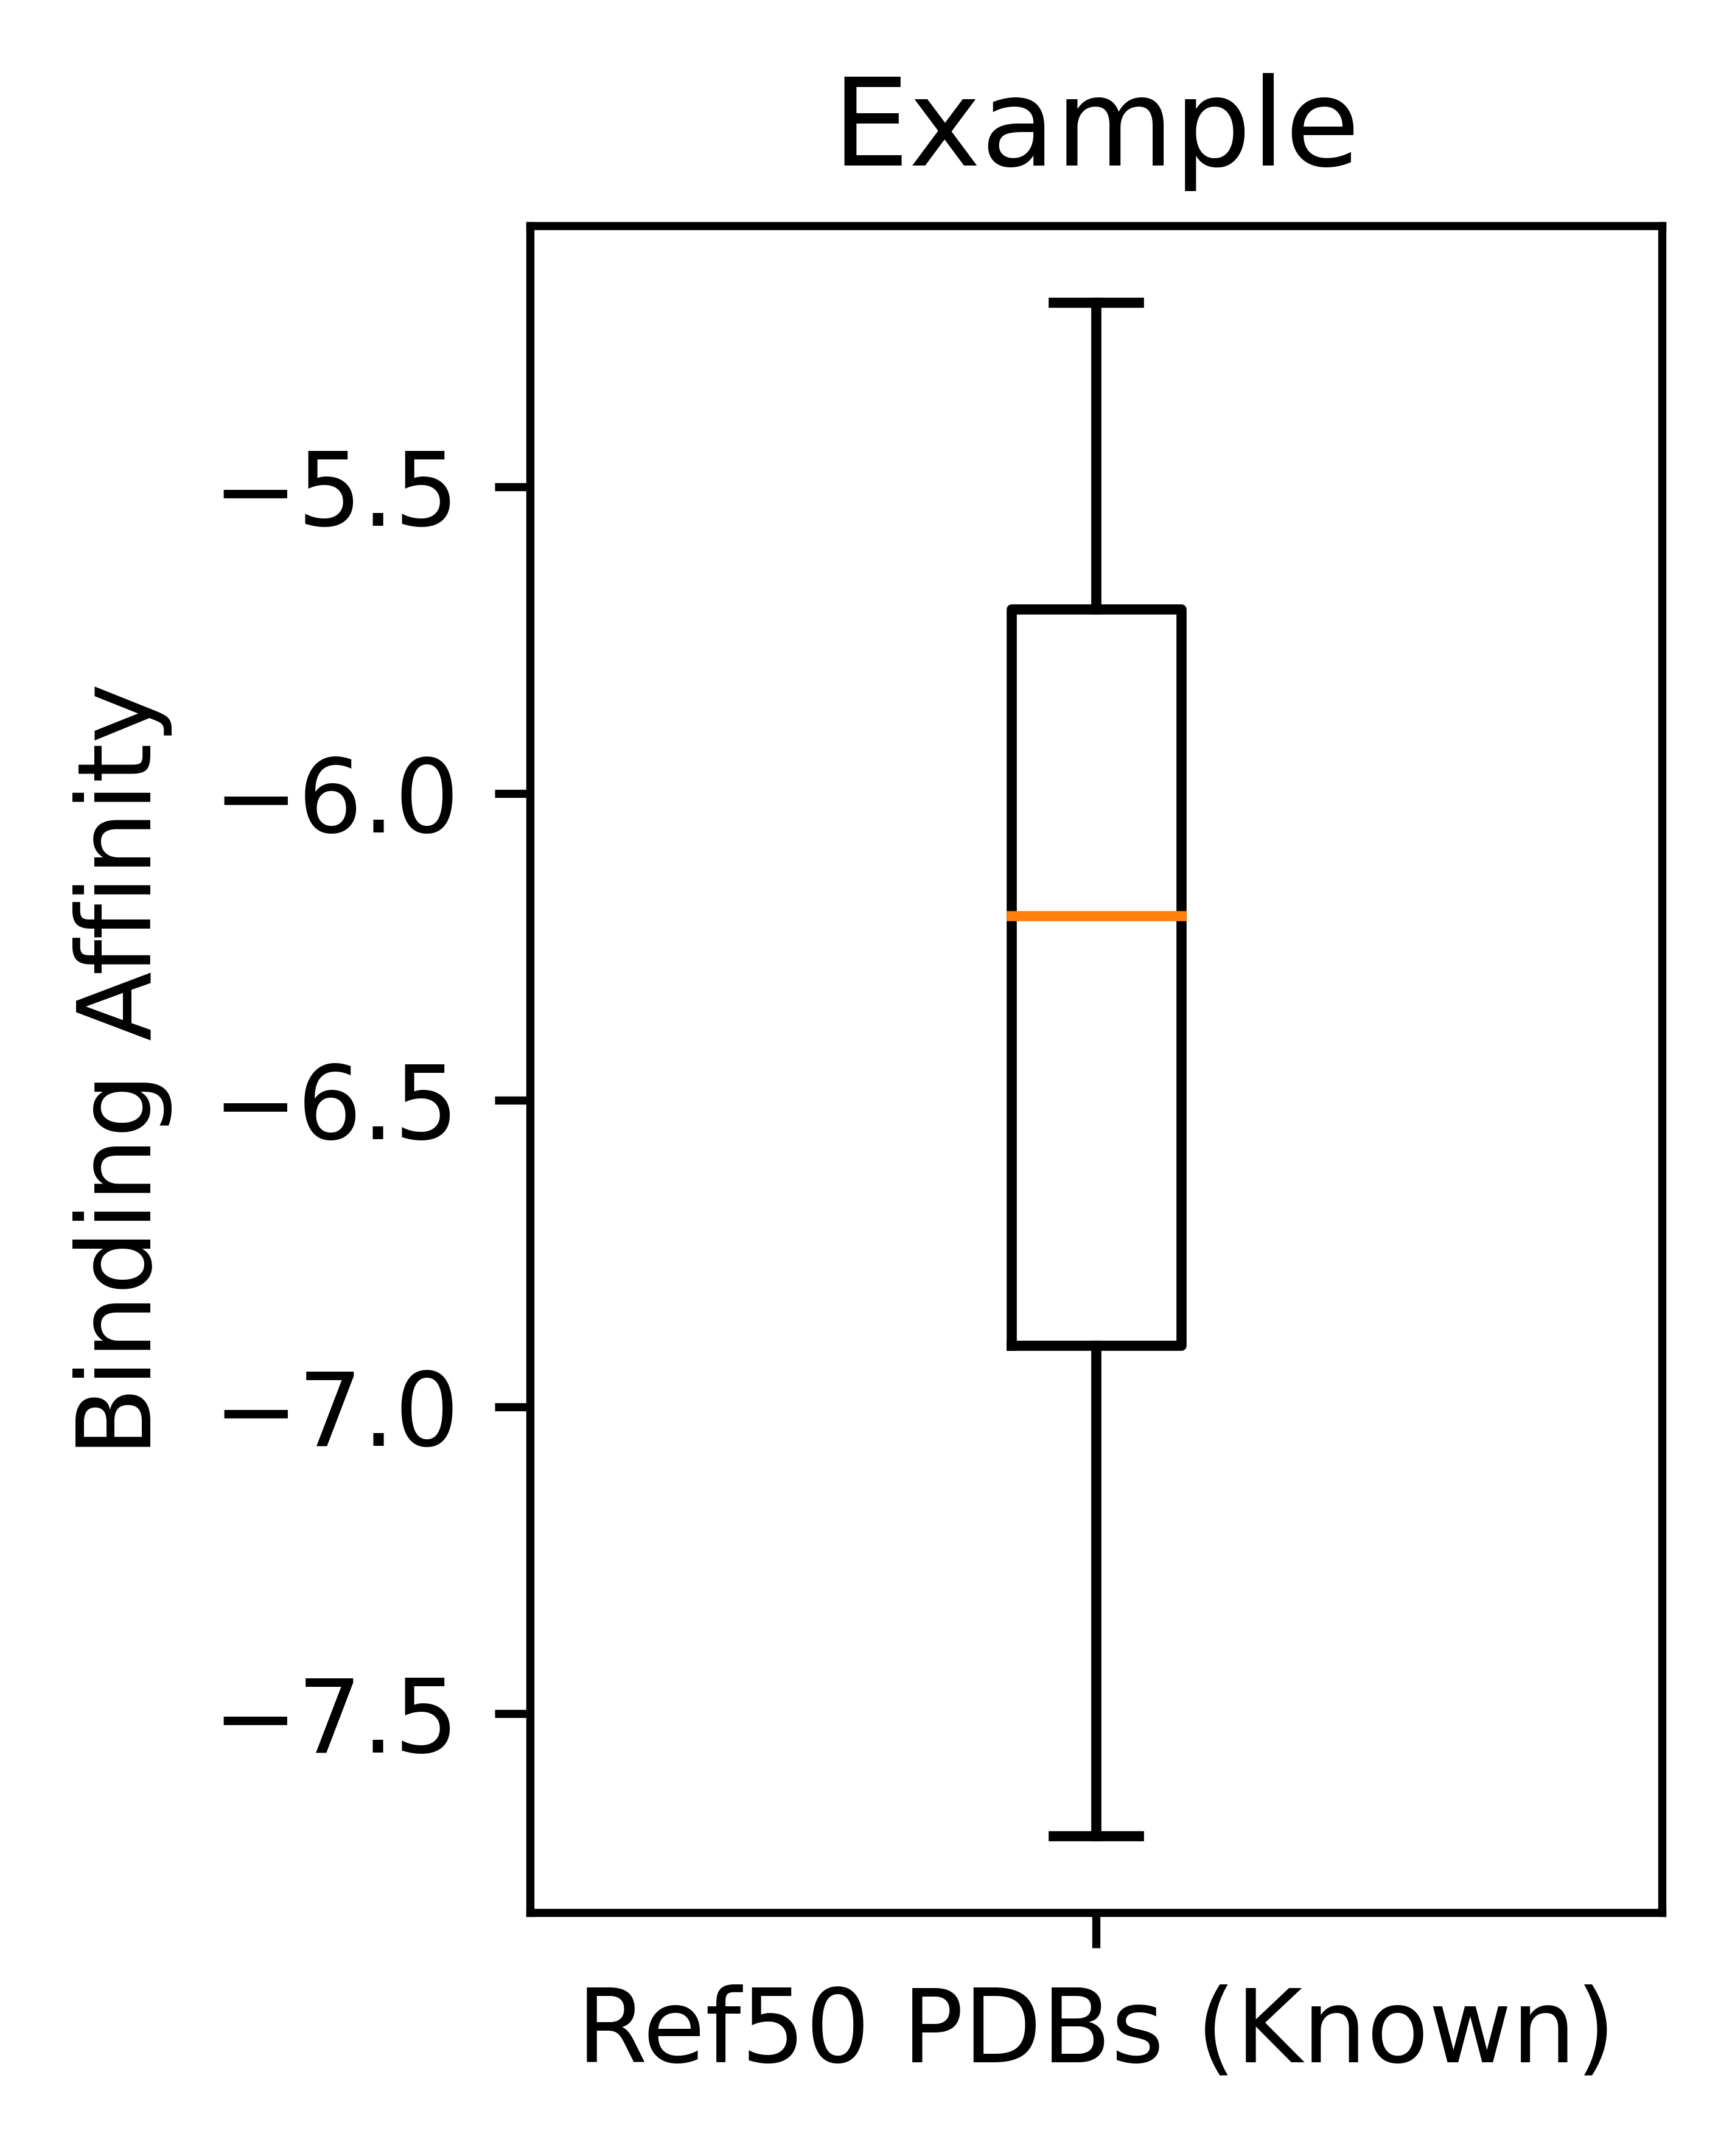

In [ ]:
#@title Set Loss.
#@markdown All Loss will be finally normalized. And Max_loss is used for Weighting.
#@markdown - For other loss or customizing loss, please use a downloaded version.


PLDDTLoss = []
POSLoss = []
#@markdown Parameters for Truncated PLDDT Loss (With max loss=1)
Truncated_PLDDT_Loss = True #@param {type:"boolean"}
target =  80 #@param {type:"number"}
pldd_target = target

if Truncated_PLDDT_Loss:
  PLDDTLoss += [TruncatedAveragePLDDTLoss(30, target)]

#@markdown Parameters for Contact Density Loss:
#@markdown - Enhance numbers of contact in proteins to make it globularm typically value: 0.035 for L<=150, 0.015 for L<=400
Contact_Density_Loss = True #@param {type:"boolean"}
target = 0.035 #@param {type:"number"}
max_loss =  2 #@param {type:"number"}
activate_PLDDT = 30 #@param {type: "number"}
cdl_max_loss, cdl_target, cdl_activate = target, max_loss, activate_PLDDT

if Contact_Density_Loss:
  POSLoss += [ContactDensityLoss(target_density=cdl_target, max_loss=cdl_max_loss,
                 plddt_activate_value=cdl_activate)]

#@markdown Parameters for Explicit Binding Loss (Time Consuming):
Explicit_Binding_Loss = True #@param {type:"boolean"}
#@markdown - Target value varies for different molecules, one can provide a positive numerical value or use Auto functions. Auto functions benchmarked the binding with N(N<=49) reference peptides and use 1.5*max(score)
#@markdown - The Auto function may need a significant amount of time (~Dock Ntimes)
target =  "Auto-5" #@param {type:"raw"}

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!TODO!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!#

max_loss =  5 #@param {type:"number"}
activate_PLDDT = 50 #@param {type: "number"}
mbl_max_loss, mbl_target, mbl_activate = max_loss, target, activate_PLDDT
use_example = True #@param {type:"boolean"}
mbl_file = None

#@markdown - If you selected MBL (and not example), please upload the required file (Ligand in PDBQT Format). Examples are in Hallucinator/Molecules:
if Explicit_Binding_Loss and not use_example:
  from google.colab import files
  filename = files.upload()
  for f in filename:
    os.rename(f, f'molecules/{f}')
    print(f'Moved "{f}" to the ./molecules/ directory')
  mbl_file = 'molecules/'+f
if use_example:
  mbl_file = 'Hallucinator/molecules/Example.pdbqt'


if Explicit_Binding_Loss:
  POSLoss += [MoleculeBindingAffinityLoss(mbl_file, max_loss=mbl_max_loss,
                      target_score=mbl_target,
                      plddt_activate_value=mbl_activate)]

#@markdown Parameters for Implicit Cavity Loss (Time Efficient with Step>=0.5):
Implicit_Cavity_Loss = True #@param {type:"boolean"}
#@markdown - Target value varies for different molecules
Tolerate_Volume_Diff =  500 #@param {type:"number"}
#@markdown - Smaller Step will make cavity calculation more accurate but also more expensive
Step_KVFinder = 0.6 #@param {type:"number"}
#@markdown - Whether sidechains are ignored when calculating cavities.
Ignore_Sidechains = False #@param {type: "boolean"}
max_loss =  5 #@param {type:"number"}
activate_PLDDT = 50 #@param {type: "number"}
ccl_max_loss, ccl_activate = max_loss, activate_PLDDT
use_example = True #@param {type:"boolean"}
ccl_file = None

#@markdown - If you selected ICL (and not example), please upload the required file (Ligand in PDB Format, the Occ column to be vdw radius). Examples are in Hallucinator/Molecules:
if Implicit_Cavity_Loss and not use_example:
  from google.colab import files
  filename = files.upload()
  for f in filename:
    os.rename(f, f'molecules/{f}')
    print(f'Moved "{f}" to the ./molecules/ directory')
  ccl_file = 'molecules'+ f
if use_example:
  ccl_file = 'Hallucinator/molecules/Example.pdb'
print(ccl_file)

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!TODO!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!#

if Implicit_Cavity_Loss:
  POSLoss += [CavityContainingLoss(ccl_file, volume_factor=0.01,
                  volume_expansion=Tolerate_Volume_Diff,
                  similarity_factor=20, similarity_target_diff=0,
                  sample_points=10, step=Step_KVFinder,
                  backbone_cavity=Ignore_Sidechains,
                  max_loss=ccl_max_loss, plddt_activate_value=ccl_activate)]



INFO:Logger:[JOBID]: Start with job name FixSequenceTest2.
INFO:Logger:[RANDS]: Random seed set as 3811874878
INFO:Logger:[SECIT]: Initial Sequence Provided with random mutate rate 0%
INFO:Logger:[SECIT]: PIAQIHILEGRSDEQKETLIREVSEAISRSLDAPLTSVRVIITEMAKGHFGIGGELASK
INFO:Logger:[DFLOG]: Difference compared to Target(Parent) RMSD 0.0
INFO:Logger:[DFLOG]: Difference compared to Target(Parent) RMSD 0.0
INFO:Logger:[DFLOG]: Difference compared to Target(Parent) Seqc 0
INFO:Logger:[DFLOG]: Difference compared to Target(Parent) RMSD 0.0
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 94.78, 'Contact %': 4.61, 'Affinity': -5.3, 'Diff volume': 177.98, 'ConFactor': (inf, 1, 0.03)}
INFO:Logger:[TEMMD]: Adaptive temperature control used with parameter (1e-09, 5)
INFO:Logger:[TEMMD]: Following temperature parameter given (max,min) -> (0.05000, 0.01000)
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 94.81, 'Contact %': 4.61, 'Affinity': -5.7, 'Diff volume': 177.98, 'ConFactor

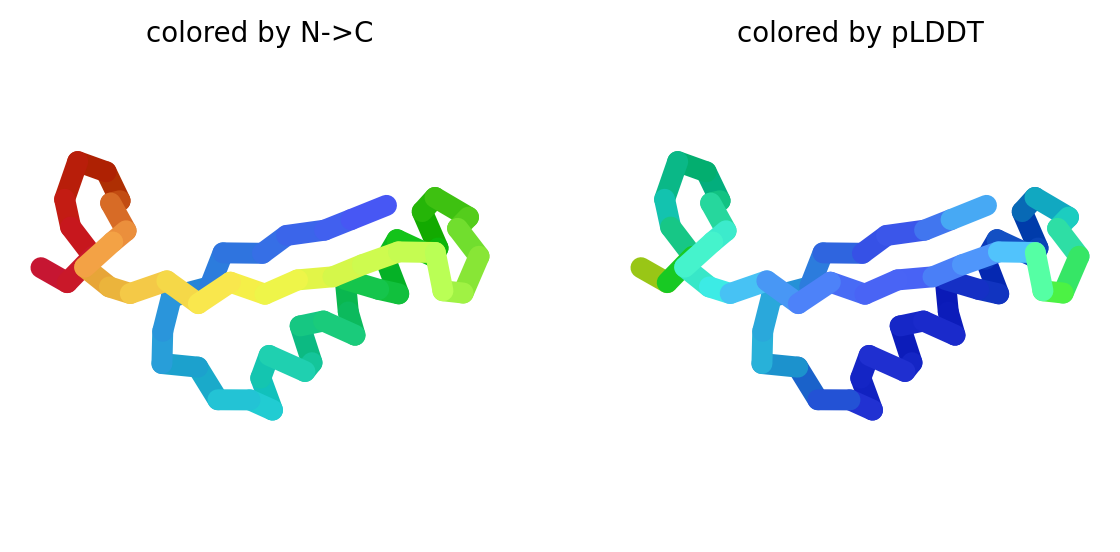

INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 84.78, 'Contact %': 4.26, 'Affinity': -5.7, 'Diff volume': 177.98, 'ConFactor': (inf, 1, 0.03)}
INFO:Logger:[DFLOG]: Difference compared to Target(Parent) RMSD 0.73
INFO:Logger:[MCLOG]: Step: 101, New Loss: 0.417, Curr Loss: 0.417, Best Loss: 0.403, Accepted: √ with temp 1.0 and prob 1.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 87.34, 'Contact %': 4.4, 'Affinity': -5.7, 'Diff volume': 177.98, 'ConFactor': (inf, 1, 0.03)}
INFO:Logger:[DFLOG]: Difference compared to Target(Parent) RMSD 0.86
INFO:Logger:[MCLOG]: Step: 102, New Loss: 0.417, Curr Loss: 0.417, Best Loss: 0.403, Accepted: √ with temp 1.0 and prob 1.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 87.42, 'Contact %': 4.4, 'Affinity': -5.7, 'Diff volume': 177.98, 'ConFactor': (inf, 1, 0.03)}
INFO:Logger:[DFLOG]: Difference compared to Target(Parent) RMSD 0.79
INFO:Logger:[MCLOG]: Step: 103, New Loss: 0.417, Curr Loss: 0.417, Best Los

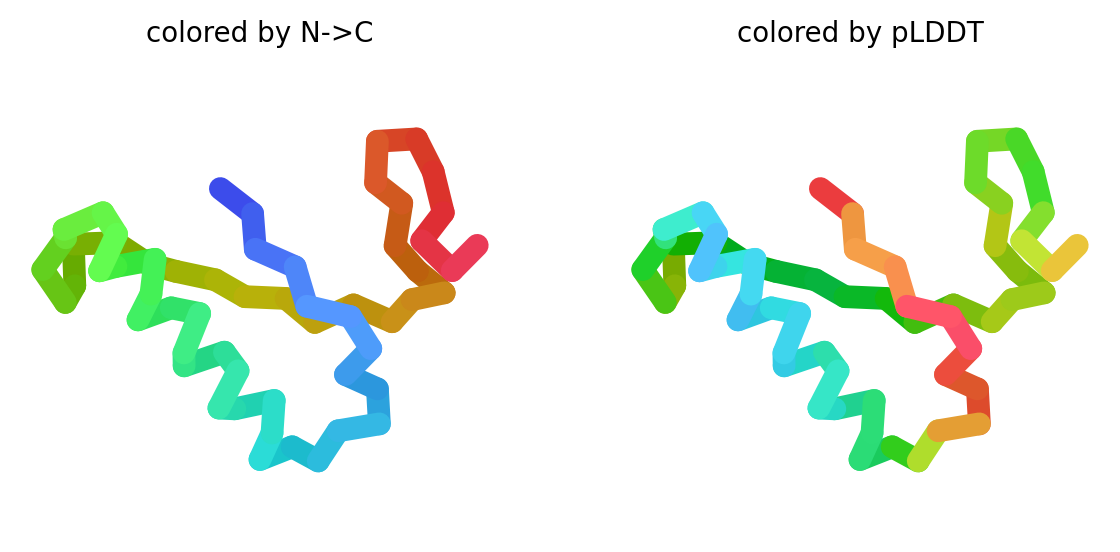

INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 49.05, 'Contact %': 0.28}
INFO:Logger:[DFLOG]: Difference compared to Target(Parent) RMSD 4.53
INFO:Logger:[MCLOG]: Step: 201, New Loss: 0.965, Curr Loss: 0.133, Best Loss: 0.133, Accepted: × with temp 1.0 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 58.32, 'Contact %': 1.05, 'Affinity': -5.28, 'Diff volume': 145.36, 'ConFactor': (0.85, 1, 1)}
INFO:Logger:[DFLOG]: Difference compared to Target(Parent) RMSD 4.53
INFO:Logger:[MCLOG]: Step: 202, New Loss: 0.697, Curr Loss: 0.133, Best Loss: 0.133, Accepted: × with temp 1.0 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 66.56, 'Contact %': 1.61, 'Affinity': -6.02, 'Diff volume': 63.51, 'ConFactor': (0.11, 0.11, 0.0)}
INFO:Logger:[DFLOG]: Difference compared to Target(Parent) RMSD 4.53
INFO:Logger:[MCLOG]: Step: 203, New Loss: 0.219, Curr Loss: 0.133, Best Loss: 0.133, Accepted: × with temp 1.0 and prob 0.000
INFO:Logger:[LS

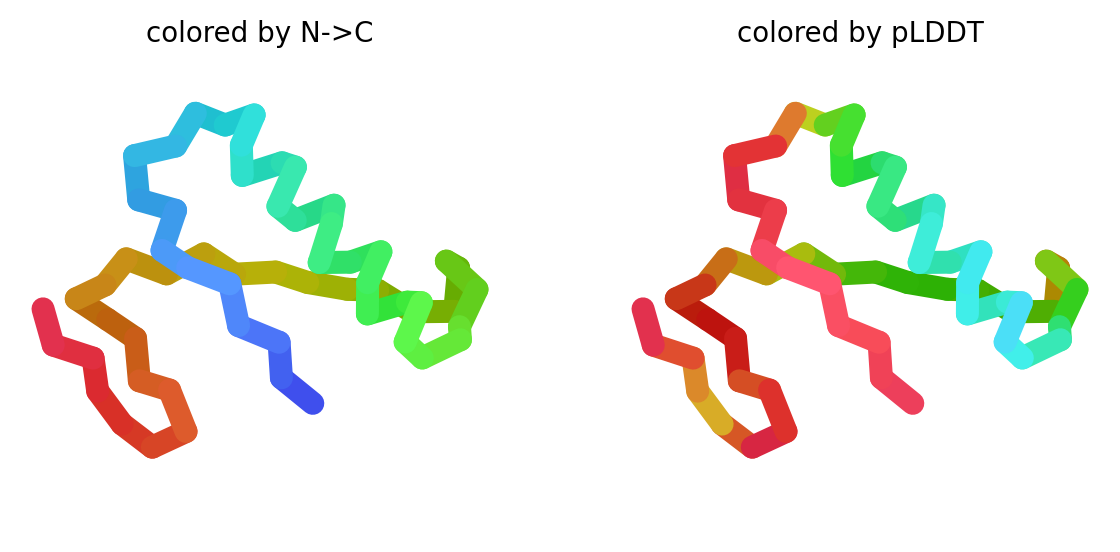

INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 61.08, 'Contact %': 1.68, 'Affinity': -6.17, 'Diff volume': 211.25, 'ConFactor': (0.04, 0.04, 0.04)}
INFO:Logger:[DFLOG]: Difference compared to Target(Parent) RMSD 4.55
INFO:Logger:[MCLOG]: Step: 301, New Loss: 0.216, Curr Loss: 0.216, Best Loss: 0.133, Accepted: √ with temp 5.0 and prob 0.700
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 47.39, 'Contact %': 0.84}
INFO:Logger:[DFLOG]: Difference compared to Target(Parent) RMSD 4.55
INFO:Logger:[MCLOG]: Step: 302, New Loss: 0.968, Curr Loss: 0.216, Best Loss: 0.133, Accepted: × with temp 5.0 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 53.0, 'Contact %': 5.1, 'Affinity': -5.56, 'Diff volume': 172.58, 'ConFactor': ('Unstable', 1, 1)}
INFO:Logger:[DFLOG]: Difference compared to Target(Parent) RMSD 4.55
INFO:Logger:[MCLOG]: Step: 303, New Loss: 0.693, Curr Loss: 0.216, Best Loss: 0.133, Accepted: × with temp 5.0 and prob 0.000
INFO:Logg

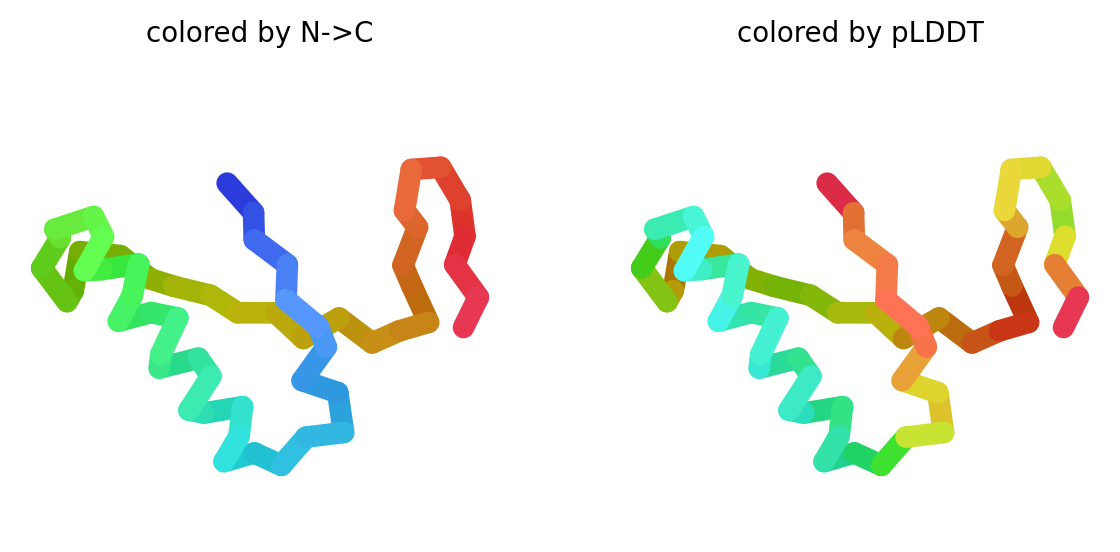

INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 67.61, 'Contact %': 3.49, 'Affinity': -6.7, 'Diff volume': 124.84, 'ConFactor': (0.73, 1, 1)}
INFO:Logger:[DFLOG]: Difference compared to Target(Parent) RMSD 3.74
INFO:Logger:[MCLOG]: Step: 401, New Loss: 0.613, Curr Loss: 0.170, Best Loss: 0.133, Accepted: × with temp 1.0 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 69.25, 'Contact %': 1.61, 'Affinity': -6.58, 'Diff volume': 371.74, 'ConFactor': (0.12, 0.13, 0.21)}
INFO:Logger:[DFLOG]: Difference compared to Target(Parent) RMSD 3.74
INFO:Logger:[MCLOG]: Step: 402, New Loss: 0.239, Curr Loss: 0.170, Best Loss: 0.133, Accepted: × with temp 1.0 and prob 0.001
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 47.08, 'Contact %': 0.49}
INFO:Logger:[DFLOG]: Difference compared to Target(Parent) RMSD 3.74
INFO:Logger:[MCLOG]: Step: 403, New Loss: 0.969, Curr Loss: 0.170, Best Loss: 0.133, Accepted: × with temp 1.0 and prob 0.000
INFO:Logger:[L

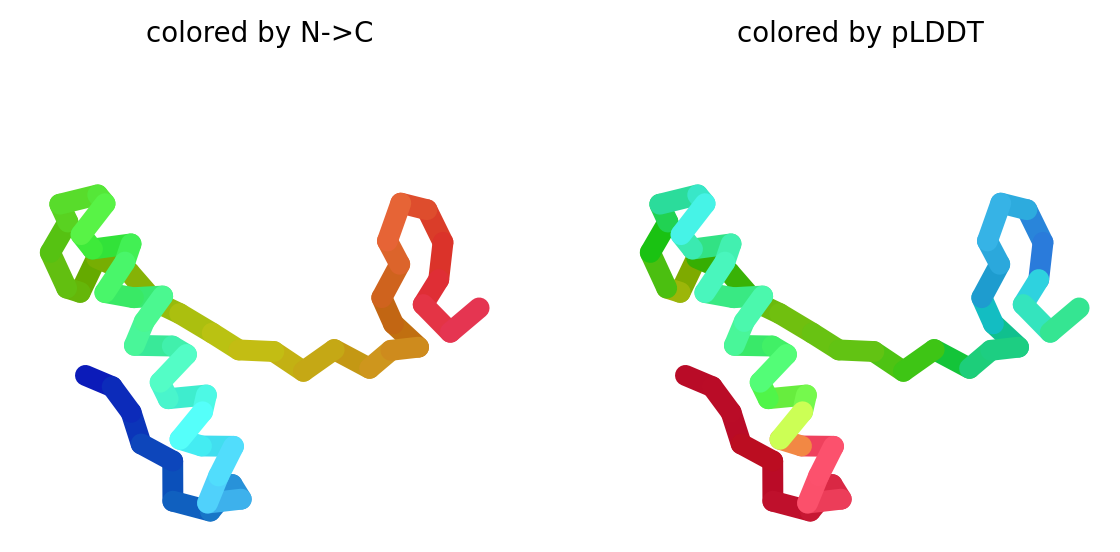

INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 69.61, 'Contact %': 1.54, 'Affinity': -6.67, 'Diff volume': 198.51, 'ConFactor': (0.16, 0.38, 0.03)}
INFO:Logger:[DFLOG]: Difference compared to Target(Parent) RMSD 6.53
INFO:Logger:[MCLOG]: Step: 501, New Loss: 0.252, Curr Loss: 0.154, Best Loss: 0.133, Accepted: × with temp 1.0 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 53.46, 'Contact %': 0.14, 'Affinity': -6.43, 'Diff volume': 166.75, 'ConFactor': (0.95, 1, 1)}
INFO:Logger:[DFLOG]: Difference compared to Target(Parent) RMSD 6.53
INFO:Logger:[MCLOG]: Step: 502, New Loss: 0.651, Curr Loss: 0.154, Best Loss: 0.133, Accepted: × with temp 1.0 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 62.39, 'Contact %': 1.47, 'Affinity': -5.98, 'Diff volume': 144.94, 'ConFactor': (0.14, 0.27, 0.02)}
INFO:Logger:[DFLOG]: Difference compared to Target(Parent) RMSD 6.53
INFO:Logger:[MCLOG]: Step: 503, New Loss: 0.269, Curr Loss: 0.15

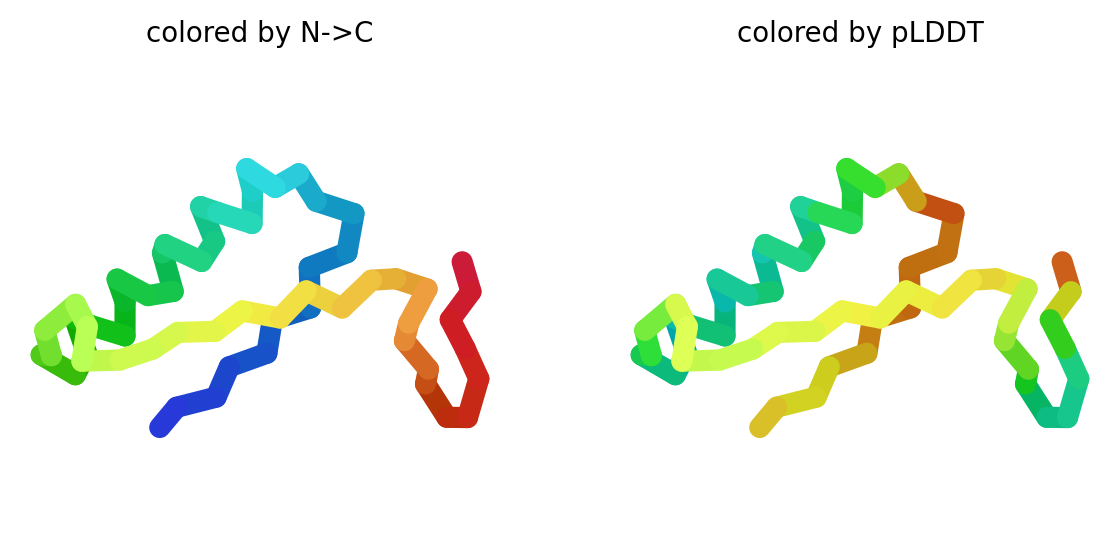

INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 77.12, 'Contact %': 0.0, 'Affinity': -5.6, 'Diff volume': 177.98, 'ConFactor': (inf, 1, 0.03)}
INFO:Logger:[DFLOG]: Difference compared to Target(Parent) RMSD 2.54
INFO:Logger:[MCLOG]: Step: 601, New Loss: 0.427, Curr Loss: 0.212, Best Loss: 0.133, Accepted: × with temp 1.0 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 66.15, 'Contact %': 2.66, 'Affinity': -6.62, 'Error': 'pos loss'}
INFO:Logger:[DFLOG]: Difference compared to Target(Parent) RMSD 2.54
INFO:Logger:[MCLOG]: Step: 602, New Loss: 0.619, Curr Loss: 0.212, Best Loss: 0.133, Accepted: × with temp 1.0 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 46.78, 'Contact %': 0.21}
INFO:Logger:[DFLOG]: Difference compared to Target(Parent) RMSD 2.54
INFO:Logger:[MCLOG]: Step: 603, New Loss: 0.970, Curr Loss: 0.212, Best Loss: 0.133, Accepted: × with temp 1.0 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'

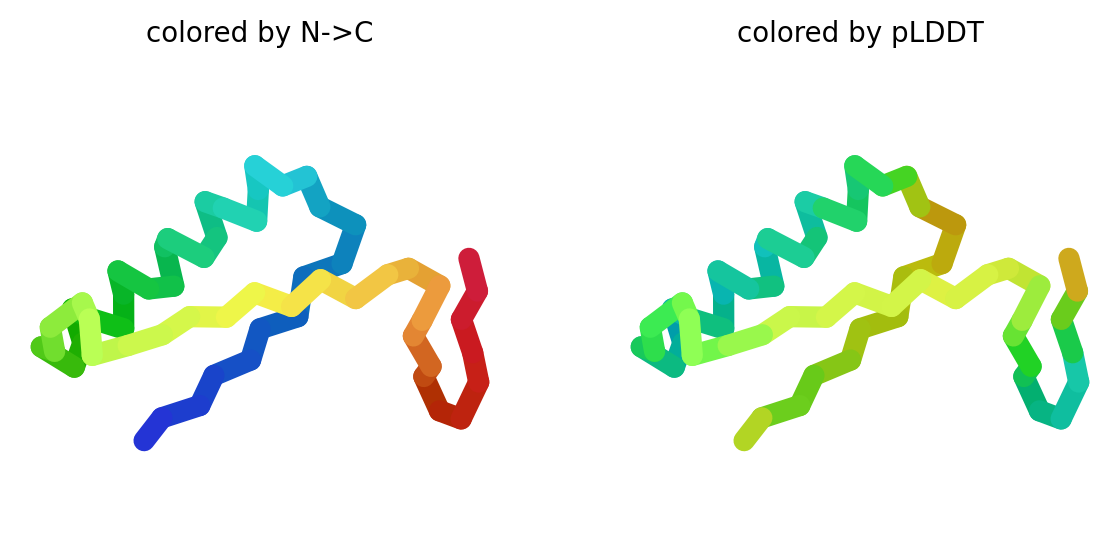

INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 62.2, 'Contact %': 1.96, 'Affinity': -5.89, 'Error': 'pos loss'}
INFO:Logger:[DFLOG]: Difference compared to Target(Parent) RMSD 2.8
INFO:Logger:[MCLOG]: Step: 701, New Loss: 0.661, Curr Loss: 0.101, Best Loss: 0.101, Accepted: × with temp 1.0 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 69.46, 'Contact %': 1.61, 'Affinity': -7.01, 'Diff volume': 313.42, 'ConFactor': (0.09, 0.07, 0.12)}
INFO:Logger:[DFLOG]: Difference compared to Target(Parent) RMSD 2.8
INFO:Logger:[MCLOG]: Step: 702, New Loss: 0.186, Curr Loss: 0.101, Best Loss: 0.101, Accepted: × with temp 1.0 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 69.34, 'Contact %': 1.4, 'Affinity': -6.91, 'Diff volume': 336.96, 'ConFactor': (0.11, 0.09, 0.15)}
INFO:Logger:[DFLOG]: Difference compared to Target(Parent) RMSD 2.8
INFO:Logger:[MCLOG]: Step: 703, New Loss: 0.201, Curr Loss: 0.101, Best Loss: 0.101, Accepted: × w

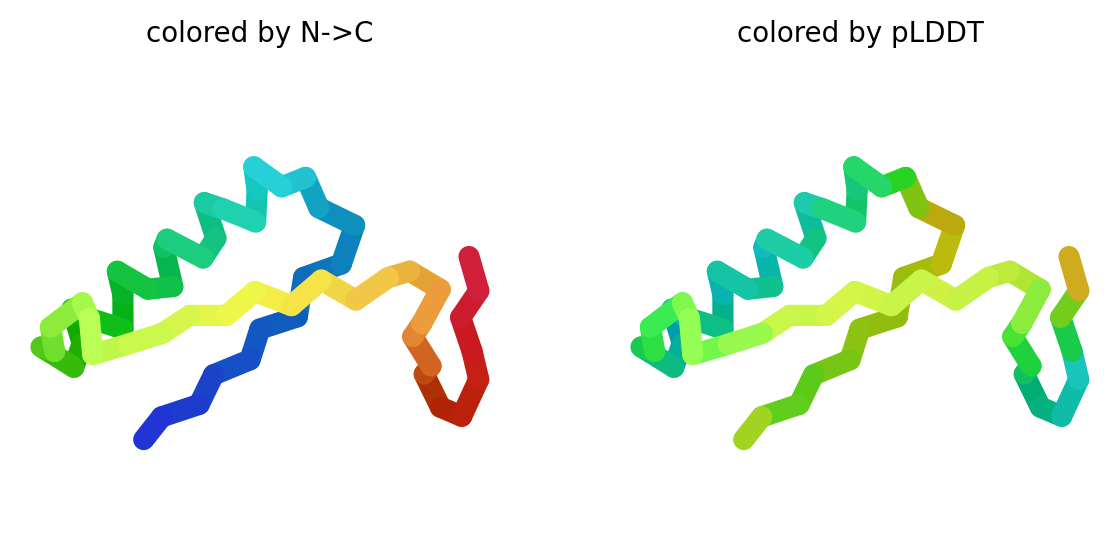

INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 72.86, 'Contact %': 1.26, 'Affinity': -8.5, 'Diff volume': 459.22, 'ConFactor': (0.1, 0.06, 0.39)}
INFO:Logger:[DFLOG]: Difference compared to Target(Parent) RMSD 2.81
INFO:Logger:[MCLOG]: Step: 801, New Loss: 0.167, Curr Loss: 0.094, Best Loss: 0.094, Accepted: × with temp 2.6 and prob 0.057
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 71.93, 'Contact %': 2.03, 'Affinity': -7.13, 'Diff volume': 204.99, 'ConFactor': (0.14, 0.17, 0.04)}
INFO:Logger:[DFLOG]: Difference compared to Target(Parent) RMSD 2.81
INFO:Logger:[MCLOG]: Step: 802, New Loss: 0.177, Curr Loss: 0.094, Best Loss: 0.094, Accepted: × with temp 2.7 and prob 0.044
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 74.46, 'Contact %': 2.45, 'Affinity': -6.4, 'Diff volume': 111.88, 'ConFactor': (0.67, 1, 1)}
INFO:Logger:[DFLOG]: Difference compared to Target(Parent) RMSD 2.81
INFO:Logger:[MCLOG]: Step: 803, New Loss: 0.614, Curr Loss: 0.094, 

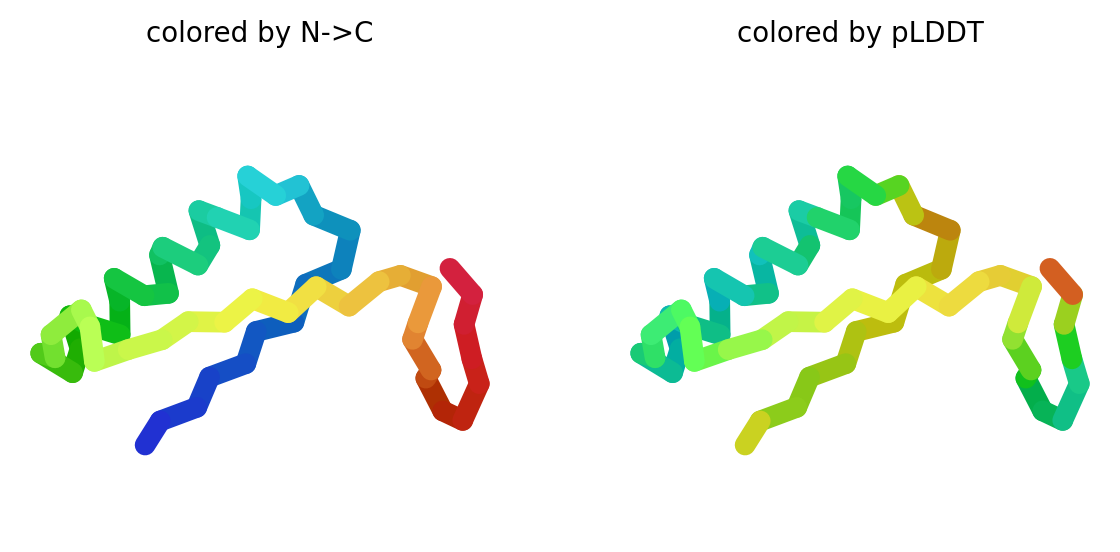

INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 60.85, 'Contact %': 1.61, 'Affinity': -6.0, 'Error': 'pos loss'}
INFO:Logger:[DFLOG]: Difference compared to Target(Parent) RMSD 2.92
INFO:Logger:[MCLOG]: Step: 901, New Loss: 0.658, Curr Loss: 0.122, Best Loss: 0.094, Accepted: × with temp 3.7 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 64.29, 'Contact %': 1.12, 'Affinity': -6.4, 'Diff volume': 359.64, 'ConFactor': (0.09, 0.07, 0.19)}
INFO:Logger:[DFLOG]: Difference compared to Target(Parent) RMSD 2.92
INFO:Logger:[MCLOG]: Step: 902, New Loss: 0.238, Curr Loss: 0.122, Best Loss: 0.094, Accepted: × with temp 3.9 and prob 0.049
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 66.69, 'Contact %': 1.82, 'Affinity': -6.8, 'Diff volume': 71.07, 'ConFactor': (0.14, 0.14, 0.0)}
INFO:Logger:[DFLOG]: Difference compared to Target(Parent) RMSD 2.92
INFO:Logger:[MCLOG]: Step: 903, New Loss: 0.188, Curr Loss: 0.122, Best Loss: 0.094, Accepted: × w

In [ ]:
#@title Start Hallucinating!

import gc
import torch
import numpy as np

if 'logger' in dir():
  del logger

if torch.cuda.is_available():
  torch.cuda.empty_cache()

gc.collect()

leng = len(Initial_Sequence) if Start_From_Known_Sequence else Length
seqc = Initial_Sequence if Start_From_Known_Sequence else None
mutn = Initial_Mutation_Rate if Start_From_Known_Sequence else 0
exaa = Exclude_Amino_Acid.split(';')
job_name = None if Jobname == 'UUID4' else Jobname
pres_resid = np.asarray(Preserved_Residues.split(';')).astype('int') if Start_From_Known_Sequence else None

seqc = [seqc, None, mutn] if Start_From_Known_Sequence else None

logger = Protein_History_MCMC_Logger(
        length=leng, excluded_aas=exaa, temp=[.05, .01, (1e-9, 5)], step=Steps,
        free_guess=N_Free_Guess, seqc_provided=seqc, preserve_resid=pres_resid,
        temp_control='Adaptive', job_name=job_name,
        guess_loss_ignore=['TruncatedAveragePLDDTLoss', 'MoleculeBindingAffinityLoss'],
        plddt_loss=PLDDTLoss, pos_loss=POSLoss,
        form_loss=lambda x, y: x+y, plddt_rule=np.mean,
        pos_rule=np.sum if Loss_Rule=='Sum' else np.max,
        loss_info=True, server_online=(useESMFold=='online'))

logger.mcmc(print_level=Output_Render_Frequency, allow_convergence=0)
